In [1]:
# Generate button to toggle (show/hide) the code cells:
from IPython.display import HTML
HTML('''
<script type=\"text/javascript\">
  function onoff(){
    currentvalue = document.getElementById('onoff').value;
    if(currentvalue == \"Hide Code\"){
      $('div.input').hide();
      document.getElementById(\"onoff\").value=\"Show Code\";
    }else{
      $('div.input').show();
      document.getElementById(\"onoff\").value=\"Hide Code\";
    }
  }
  $( document ).ready(onoff);
</script>
<input type=\"button\" value=\"Show Code\" id=\"onoff\" onclick=\"onoff();\">
''')

# TFM - TREJO

**Author**: Nicolás Trejo  
Madrid, may 20th 2020

---

**Ideas**:

- incorporar como un indicador más la nota del alumno (viene del "grade_report")
- incorporar los logs de marzo en adelante (volver a correr bridging_mongo)
- descartar el uso de problemas como indicador (eventos en problemas, diferentes problemas y tiempo en problemas)
- hacer un árbol de decisión
- estrategias frente a los datos desbalanceados

**Done**:

- incorporar info de certified de los alumnos (en enrollment_mode)
- quitar a los de UY



**Nota**: Durante COVID, hubo más alumnos matriculados como verified (ya que había promociones o descuentos). Los datos serán diferentes, así como ocurría con los de UY.

---

**Resources**:

* [Principal Component Analysis](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)
* [Árbol de Decisión | aprendeML](https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/)
* [Árbol de Decisión | medium](https://medium.com/@randerson112358/python-decision-tree-classifier-example-d73bc3aeca6#:~:text=Decision%20Trees%20are%20a%20type,things%2C%20leaves%20and%20decision%20nodes.) (ejemplo de golf, grafica el árbol de decisión) ([video](https://youtu.be/bT-43kgYI3o) de 47 min) !!!
* Datos desbalanceados:
  * [stackexchange](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data)
  * [framework for unbalanced project | machinelearningmastery](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/) !!!
  * [8 ways for unbalanced classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)


**SKLEARN**

* [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Dimensionality Reduction with Neighborhood Components Analysis](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py)

---

**Flask & Dash**

* https://flask.palletsprojects.com/en/1.1.x/config/
* https://dash.plotly.com/layout

---

**Random links**

* [GitHub repositories about LA](https://github.com/search?q=learning+analytics&type=Repositories)
* [Absolute vs Relative Import | Real Python](https://realpython.com/absolute-vs-relative-python-imports/)
* [Modules packages | Real Python](https://realpython.com/python-modules-packages/)
* [K-Means Clustering | datacamp](https://www.datacamp.com/community/tutorials/k-means-clustering-python)


## Imports and functions

Using matplotlib, pandas, numpy, sklearn among others

In [2]:
# Python version 3.6.8
# Jupyter Notebook version 4.4.0
# Author: Nicolas Trejo
# Madrid, Spain
# May 2020

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# import gzip
# import os
# import pickle
import random
# import sys
# import time
# from datetime import datetime

from IPython.display import Image  # To Display an image of graph
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib.colors import ListedColormap
from pandas.plotting import register_matplotlib_converters
import pydotplus  # To create Decision Tree Graph
from sklearn import tree  # For Decision Tree
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


register_matplotlib_converters()
random.seed(123456)  # Using seed for debuging purposes

# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, r2_score #, mean_squared_error
# from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold  #, cross_val_score
# from sklearn.neural_network import MLPRegressor

In [4]:
# My function for Root Mean Squared Error:

# def rmse(y, y_pred):
#     return np.sqrt(np.mean(np.square(y - y_pred)))

# def PCA_data(data):
    
#     data_mean = data.mean(axis=0)                                   # calculo de las medias de cada variable teniendo en cuenta todos los datos
#     data_0_mean = data - data_mean                                  # resta la media a cada dato
#     data_cov = np.dot(data_0_mean.T,data_0_mean)/(data.shape[1]-1)  # calcula la matriz de covarianzas de dimension n x n
#     n = data_cov.shape[0]                                           # dimension de la matriz de covarianzas
#     eigenValues, eigenVectors = np.linalg.eigh(data_cov)            # calcula autovectores y autovalores
#     idx = np.argsort(eigenValues)[::-1][:n]                         # ordena en orden descendente los autovalores y autovectores
#     eigenValues = eigenValues[idx]
#     eigenVectors = eigenVectors[:,idx]
#     del idx                                                         # borra el indice de ordenacion

#     return data_mean, eigenValues, eigenVectors

def data_overview(name, dataframe):
    print(name)
    print('\tNumber of Rows: {0}\tNumber of Columns: {1}'.format(dataframe.shape[0], dataframe.shape[1]))
    print('\tColumns:\n{}\n'.format(list(dataframe.columns)))

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set

## Data loading

Files to load:

- **allIndicators.csv** *(obtained from logs)*
- **profiles.csv** *(students in course)*
- **discourageResponsesIQ_NUM_grades_group_2020_07_20.csv** *(obtained from surveyProcessing)*


In [5]:
# FILES & FOLDERS

FOLDER_PATH = '/home/nicolas/ACCOMP/OUTPUT-2020-08-25/'  # '/home/nicolas/ACCOMP/OUTPUT-2020-03-10/'
ALL_INDICATORS = FOLDER_PATH + 'allIndicators.csv'

FOLDER_REQUIRED = '/home/nicolas/ACCOMP/REQUIRED_FILES/'
PROFILES = FOLDER_REQUIRED + 'profiles.csv'

FOLDER_SP_OUTPUT = '/home/nicolas/Documents/MasterII/TFM/surveyProcessing/OUTPUT/WebApp/2020-07-20/'
SP_RESPONSES = FOLDER_SP_OUTPUT + 'discourageResponsesIQ_NUM_grades_group_2020_07_20.csv'

In [6]:
# load data as pandas dataframe
df = pd.read_csv(ALL_INDICATORS)
# Read 'dt_date' correctly to datetime
df['dt_date'] = pd.to_datetime(df['dt_date'], format='%Y%m%d %H:%M', errors='raise')

df_profiles = pd.read_csv(PROFILES)
# columns: id,username,name,email,language,location,year_of_birth,gender,level_of_education,
#          mailing_address,goals,enrollment_mode,verification_status,last_login,date_joined,
#          cohort,city,country

df_sp_responses = pd.read_csv(SP_RESPONSES)
# columns: 'user_id', 'course_id', 'A) ...', 'B) ...', 'C) ...', 'D) ...', '1) ...',
#          '2) ...', '3) ...', '4) ...', '5) ...', '6) ...', '7) ...', '8) ...',
#          '9a) ...', '9b) ...', '10) ...', '11) ...', '12) ...',
#          'enrollment', 'grade', 'cert_date', 'sp_date', 'sp_date_answer', 'username', 'email'
sp_columns = ['user_id', 'course_id', 'A) País', 'B) Género:', 'C) Estudios:',
              'D) Año Nacimiento:', '1) Facilidad del curso', '2) Estructura adecuada',
              '3) Utilidad de vídeos', '4) Utilidad de no-vídeos', '5) Evaluaciones útiles',
              '6) Foros úties', '7) Utilidad Profesional', '8) Pretendo completar el curso',
              '9a) Interés en certificado', '9b) (verificado) Pretendo aprobar el curso',
              '10) (9b) Motivo para certificado', '11) En caso "otro motivo" en (10), ¿cuál?',
              '12) Tiempo semanalmente dedicado', 'enrollment', 'grade', 'cert_date', 'sp_date',
              'sp_date_answer', 'username', 'email']
df_sp_responses.columns = sp_columns

for date_col in ['sp_date_answer', 'cert_date', 'sp_date']:
    df_sp_responses[date_col] = pd.to_datetime(df_sp_responses[date_col]).dt.date

## Data overview

In [7]:
data_overview('All Indicators', df)
data_overview('Profiles', df_profiles)
data_overview('SP Responses', df_sp_responses)

All Indicators
	Number of Rows: 462672	Number of Columns: 18
	Columns:
['user_id', 'dt_date', 'num_events', 'num_sessions', 'video_time', 'problem_time', 'nav_time', 'forum_time', 'total_time', 'video_events', 'problem_events', 'forum_events', 'nav_events', 'consecutive_inactivity_days', 'connected_days', 'different_videos', 'different_problems', 'enrollment_mode']

Profiles
	Number of Rows: 21451	Number of Columns: 18
	Columns:
['id', 'username', 'name', 'email', 'language', 'location', 'year_of_birth', 'gender', 'level_of_education', 'mailing_address', 'goals', 'enrollment_mode', 'verification_status', 'last_login', 'date_joined', 'cohort', 'city', 'country']

SP Responses
	Number of Rows: 552	Number of Columns: 26
	Columns:
['user_id', 'course_id', 'A) País', 'B) Género:', 'C) Estudios:', 'D) Año Nacimiento:', '1) Facilidad del curso', '2) Estructura adecuada', '3) Utilidad de vídeos', '4) Utilidad de no-vídeos', '5) Evaluaciones útiles', '6) Foros úties', '7) Utilidad Profesional',

### Basic statistics (indicators)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,462672.0,2.254272e+07,7.120748e+06,54060.0,19503922.0,23877848.5,24535376.0,3.641661e+07
num_events,462672.0,1.628378e+00,1.983434e+01,0.0,0.0,0.0,0.0,1.351000e+03
num_sessions,462672.0,9.386347e-02,9.241664e-01,0.0,0.0,0.0,0.0,4.100000e+01
video_time,462672.0,1.498264e+01,2.054585e+02,0.0,0.0,0.0,0.0,1.403021e+04
problem_time,462672.0,2.111813e+00,4.521067e+01,0.0,0.0,0.0,0.0,5.009413e+03
nav_time,462672.0,1.990706e+01,2.456571e+02,0.0,0.0,0.0,0.0,1.661105e+04
forum_time,462672.0,6.945225e-01,2.335583e+01,0.0,0.0,0.0,0.0,4.104798e+03
total_time,462672.0,3.779815e+01,4.465244e+02,0.0,0.0,0.0,0.0,2.383375e+04
video_events,462672.0,8.130836e-01,1.168912e+01,0.0,0.0,0.0,0.0,9.170000e+02
problem_events,462672.0,1.766024e-01,2.994755e+00,0.0,0.0,0.0,0.0,3.400000e+02


In [9]:
# Looking for missing values
df.isna().sum()

user_id                             0
dt_date                             0
num_events                          0
num_sessions                        0
video_time                          0
problem_time                        0
nav_time                            0
forum_time                          0
total_time                          0
video_events                        0
problem_events                      0
forum_events                        0
nav_events                          0
consecutive_inactivity_days         0
connected_days                      0
different_videos                    0
different_problems                  0
enrollment_mode                218662
dtype: int64

In [10]:
# Understand enrollment data
df.groupby('enrollment_mode').size()

enrollment_mode
audit          7106
certified      9991
verified     226913
dtype: int64

In [11]:
# Top 10 countries for all users (audit or verified)
df_profiles.groupby('country').size().sort_values(ascending=False).head(10)

country
ES    4227
MX    2804
CO    2612
AR    2446
PE    2190
UY     884
EC     778
VE     622
CL     609
CR     591
dtype: int64

In [12]:
# Top 10 countries for verified users
df_profiles[df_profiles['enrollment_mode']=='verified'].groupby('country').size().sort_values(ascending=False).head(10)

country
UY    550
ES    204
MX     34
US     19
PE     14
CO     11
CL     11
EC     11
AR     11
GT      6
dtype: int64

In [13]:
# Codify enrollment mode into numbers
ordered_modes = ['audit', 'verified', 'certified']  # unknown
#                 0        1           2              -1

df['enrollment_mode'] = pd.Categorical(df['enrollment_mode'],
                                       ordered=True, 
                                       categories=ordered_modes).codes #.cat.codes
df.groupby('enrollment_mode').size()

enrollment_mode
-1    218662
 0      7106
 1    226913
 2      9991
dtype: int64

In [14]:
# Obtain a np.array of unique users
unique_user_id_total = df_profiles['id'].unique()
unique_user_id = df['user_id'].unique()
print(f'Users: {len(unique_user_id_total)} (verified {len(unique_user_id)})')

UY_mask = df_profiles['country']=='UY'
users_UY_total = df_profiles[UY_mask]['id'].to_numpy(copy=True)
users_UY = df_profiles[UY_mask & (df_profiles['enrollment_mode']=='verified')]['id'].to_numpy(copy=True)
print(f'UY users: {len(users_UY_total)} (verified {len(users_UY)})')

Users: 21451 (verified 918)
UY users: 884 (verified 550)


In [15]:
# LIST OF FEATURES AND TARGET VARIABLES

l_features = list( df.columns[2 : 17] )
l_features = ['num_events', 'num_sessions', 'video_time', 'nav_time', 'forum_time',
              'total_time', 'video_events', 'forum_events', 'nav_events',
              'consecutive_inactivity_days', 'connected_days', 'different_videos']
target     = df.columns[17]

print('Features:', l_features)
print('Target:', target)

Features: ['num_events', 'num_sessions', 'video_time', 'nav_time', 'forum_time', 'total_time', 'video_events', 'forum_events', 'nav_events', 'consecutive_inactivity_days', 'connected_days', 'different_videos']
Target: enrollment_mode


In [16]:
########################
#                      #
#  filter useful data  #
#                      #
########################

# Ignoring users from UY
# Ignoring unknown enrollment (-1)

users_UY_mask = df['user_id'].isin(users_UY)
enrollment_unknown_mask = df['enrollment_mode'] == -1

df = df[~(users_UY_mask | enrollment_unknown_mask)].reset_index(drop=True)
# len(df) = 26990 (there are 133 users with aproximately 202 dates each)
df.groupby('enrollment_mode').size()

enrollment_mode
0     2496
1    68570
2      780
dtype: int64

In [17]:
# Export DF allIndicators changed:
#  - without UY users
#  - without unknown enrollment

ALL_INDICATORS_FILTERED = FOLDER_PATH + 'allIndicators_Filtered.csv'
df.to_csv(path_or_buf=ALL_INDICATORS_FILTERED, encoding='utf-8', index=False)

In [18]:
X = df[l_features].copy()
y = df['enrollment_mode'].copy()

# Split in train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=0)

# standardize the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_std = sc.transform(X)  # added by nicktrejo

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/home/nicolas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [19]:
# Obtained from:
# https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad
# # It seems this is not necessary any more

# # Covariance matrix and eigenvalues and eigenvectors
# cov_mat = np.cov(X_train_std.T)
# eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# # Make a list of (eigenvalue, eigenvector) tuples
# eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# # Sort the (eigenvalue, eigenvector) tuples from high to low
# eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# # Only considering first two Principal Components (they account for 60% info)
# w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
# print('Matrix W:\n{}'.format(w))

# # Tranform data onto the two principal components
# X_train_pca = X_train_std.dot(w)

In [20]:
# intialize pca and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='auto', solver='liblinear')

# fit and transform data
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_pca = pca.transform(X_std)
lr.fit(X_train_pca, y_train)

# explained_variance_ of PCA (first three components account for 73%)
# [int(_) for _ in pca.explained_variance_/pca.explained_variance_.sum()*100]
# eigenvectors
# pca.components_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

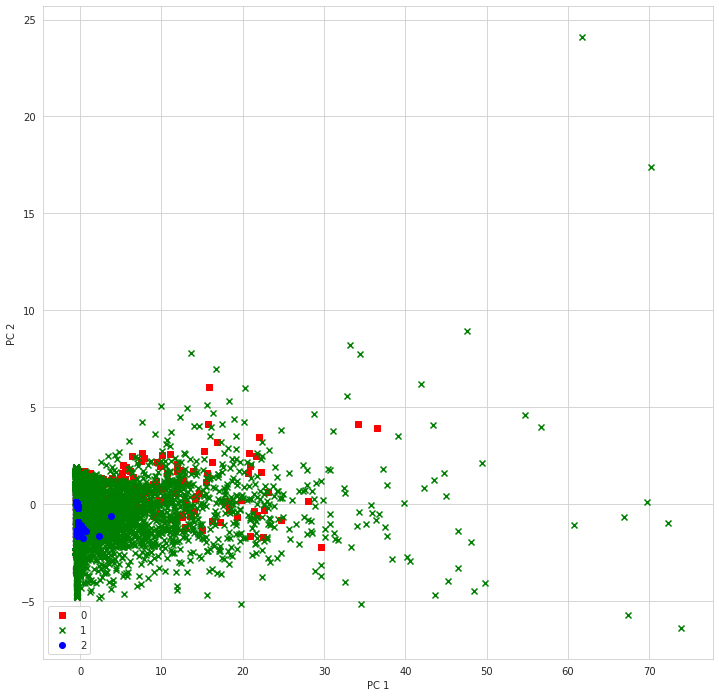

In [21]:
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
plt.figure(figsize=(12,12))
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], 
                X_train_pca[y_train==l, 1], 
                c=c, label=l, marker=m) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

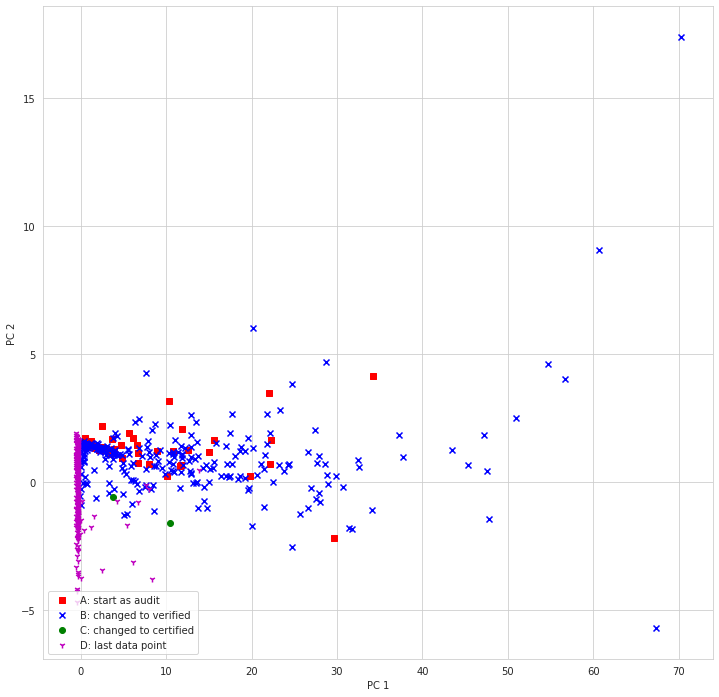

In [22]:
colors = ['r', 'b', 'g', 'm']
markers = ['s', 'x', 'o', '1']
labels = ['A: start as audit', 'B: changed to verified',
          'C: changed to certified', 'D: last data point']

index_a = df[df['enrollment_mode']==0].groupby('user_id').head(1).index
index_b = df[df['enrollment_mode']==1].groupby('user_id').head(1).index
index_c = df[df['enrollment_mode']==2].groupby('user_id').head(1).index
index_d = df.groupby('user_id').tail(1).index
index_ = [index_a, index_b, index_c, index_d]

plt.figure(figsize=(12,12))

for i in range(len(index_)):
    plt.scatter(X_pca[index_[i], 0],
                X_pca[index_[i], 1],
                c=colors[i], label=labels[i], marker=markers[i])

# plt.scatter(X_pca[index_a, 0],
#             X_pca[index_a, 1],
#             c=colors[0], label=labels[0], marker=markers[0])

# plt.scatter(X_pca[index_b, 0],
#             X_pca[index_b, 1],
#             c=colors[1], label=labels[1], marker=markers[1])

# plt.scatter(X_pca[index_c, 0],
#             X_pca[index_c, 1],
#             c=colors[2], label=labels[2], marker=markers[2])

# plt.scatter(X_pca[index_d, 0],
#             X_pca[index_d, 1],
#             c=colors[3], label=labels[3], marker=markers[3])

# axes = plt.gca()
# axes.set_xlim([None,30])
# axes.set_ylim([None,10])

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [23]:
index_c

Int64Index([8605, 29690], dtype='int64')

In [24]:
for i in index_:
    print(len(i))

137
367
2
367


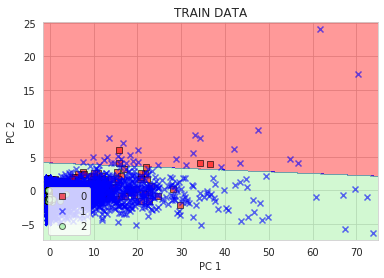

In [25]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TRAIN DATA')
plt.legend(loc='lower left')
plt.show()

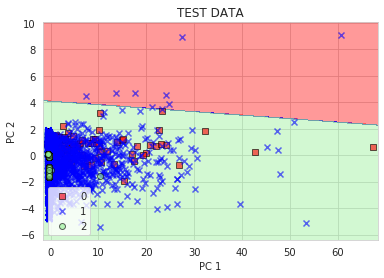

In [26]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('TEST DATA')
plt.legend(loc='lower left')
plt.show()

In [27]:
((lr.predict(X_test_pca)==y_test).sum(), len(lr.predict(X_test_pca)))

# lr.predict_proba(X[:2, :])
# lr.score(X, y)

(20562, 21554)

In [28]:
# y_test[y_test==0]

In [29]:
len(df)

71846

In [30]:
y_test_pred = lr.predict(X_test_pca)
c_matrix = confusion_matrix(y_true=y_test,
                           y_pred=y_test_pred,
                           labels=[0,1])

In [31]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print('Confusion Matrix', c_matrix, c_matrix/len(y_test)*100, sep='\n\n')

Confusion Matrix

[[    0   749]
 [    9 20562]]

[[0.000 3.475]
 [0.042 95.398]]


In [32]:
# data_mean, eigenValues, eigenVectors = PCA_data(X)  # Principal Components Analysis

In [33]:
# def codificaImagen1DArray(x, data_mean, eigenVectors, n_elements):
#     coef=np.array(np.zeros(n_elements))           
#     for i in range(n_elements):                                            # calcula el producto escalar de data y autovector
#         coef[i] = np.dot(x-data_mean,eigenVectors[:,i])
#     return coef

# def codificaImagenes1DArray(x, data_mean, eigenVectors, n_elements):
#     for i in range(x.shape[0]):
#         if i == 0:
#             coef = codificaImagen1DArray(x[i], data_mean, eigenVectors, n_elements)
#         else:
#             coef = np.vstack((coef,codificaImagen1DArray(x[i], data_mean, eigenVectors, n_elements)))
#     return coef


In [34]:
# n_elements = 1

In [35]:
# X_coded = codificaImagenes1DArray(X.to_numpy(copy=True), data_mean,
#                                   eigenVectors, n_elements)

In [36]:
# # with 2 variables

# X_coded_bis = codificaImagenes1DArray(X.to_numpy(copy=True), data_mean,
#                                       eigenVectors, n_elements+1)

In [37]:
# # Graph X_coded over time

# # cmap = plt.cm.get_cmap('viridis')  # ('hsv')

# # cm_delta = 1/len(users_yes)
# # cm_var = 0

# plt.figure(figsize=(12,12))

# for i, user_id_ in enumerate(unique_user_id):
#     if user_id_ in users_UY:
#         continue
#     nros = (df[(df['user_id']==user_id_)&(df['enrollment_mode']==0)].index)
#     nros = (df[(df['user_id']==user_id_)].index)
#     plt.plot(df.iloc[nros,1],
#              X_coded[nros],
        
#              # df.iloc[i*336:(i+1)*336,1],
#              # X_coded[i*336:(i+1)*336],
             
#              # df['dates_custom'].iloc[i], 
#              # x_coded, 
#              # color = cmap(cm_var))
#              # color = cmap((y.iloc[i*336:(i+1)*336]+1)/4)
#             )
#     # cm_var = cm_var + cm_delta


# plt.title('Componente principal')
# plt.xlabel('TIME (Days)')
# plt.ylabel('Componente principal')

# #plt.vlines(x=0, ymin=df[variable].min(), 
# #           ymax=df[variable].max(), colors='0.5', linestyles='dashed', label='')
# plt.show()
# #plt.savefig(f'{variable}.png')

In [38]:
# # Graph X_coded_bis 2 components, showing enrollment mode

# cter = 0
# descartados = 0
# cmap = plt.cm.get_cmap('viridis')  # ('hsv')
# plt.figure(figsize=(12,12))

# for i, user_id_ in enumerate(unique_user_id):
#     if user_id_ in users_UY:
#         continue

#     nros = (df[(df['user_id']==user_id_)&(df['enrollment_mode']==0)].index)

#     nros_audit = (df[(df['user_id']==user_id_)&(df['enrollment_mode']==0)].index)
#     nros_verified = (df[(df['user_id']==user_id_)&(df['enrollment_mode']==1)].index)

#     if len(nros_audit)==0 or len(nros_verified)==0:
#         continue

#     if cter == 20:
#         break
#     cter += 1

#     if X_coded_bis[nros_audit[0],0:1] > 2000:
#         descartados += 1  # 6
#         continue
#     plt.plot(X_coded_bis[nros_audit[0],0:1],
#              X_coded_bis[nros_audit[0],1:2],
#              color=cmap(1), marker='*')

# #     plt.plot(X_coded_bis[nros_audit,0:1],
# #              X_coded_bis[nros_audit,1:2],
# #              color=cmap(0.9), marker='.',
# #              linewidth=0.3, markersize=0.4)

#     if X_coded_bis[nros_verified[0],0:1] > 7500:
#         descartados += 1  # 4
#         continue
#     plt.plot(X_coded_bis[nros_verified[0],0:1],
#              X_coded_bis[nros_verified[0],1:2],
#              color=cmap(0.3), marker='+')

# #     plt.plot(X_coded_bis[nros_verified,0:1],
# #              X_coded_bis[nros_verified,1:2],
# #              color=cmap(0.3), marker='.',
# #              linewidth=0.3, markersize=0.4)

#     if X_coded_bis[nros_verified[-1],0:1] > 1000:
#         descartados += 1  # 1
#         continue
#     plt.plot(X_coded_bis[nros_verified[-1],0:1],
#              X_coded_bis[nros_verified[-1],1:2],
#              color=cmap(0.15), marker='+')


# plt.title('Componentes')
# plt.xlabel('Componente principal')
# plt.ylabel('Componente secundario')
# plt.show()

# print(descartados)

In [39]:
# df[(df['user_id']==unique_user_id[random.randint(0,len(unique_user_id))])&(df['dates_custom'].notnull())]['dates_custom'].iloc[0]

In [40]:
# for i, user_ in enumerate(unique_user_id):
#     lala = df.iloc[i*336:(i+1)*336,0].nunique()
#     if lala != 1:
#         print(f'error en i = {i}')
# len(unique_user_id)

### Boxplots

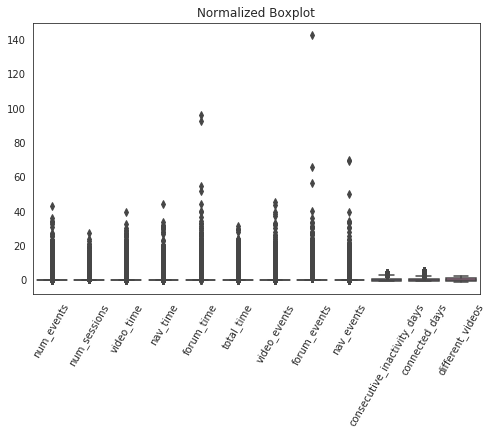

In [41]:
df_normalized = (df[l_features] - df[l_features].mean()) / df[l_features].std() #normalizar para tener rangos uniformes en histogramas

#DataFrame.insert(self, loc, column, value, allow_duplicates=False)

plt.figure( figsize=(8, 5))
sns.set_style("white")
bx_plot = sns.boxplot(data=df_normalized)
plt.xticks(rotation=60)
plt.title(label='Normalized Boxplot')
plt.show()

### Scatterplots & histograms

In [42]:
# pair_plot = sns.pairplot( df[ list(l_features[ : -1]) + [target] ] )
# plt.show()

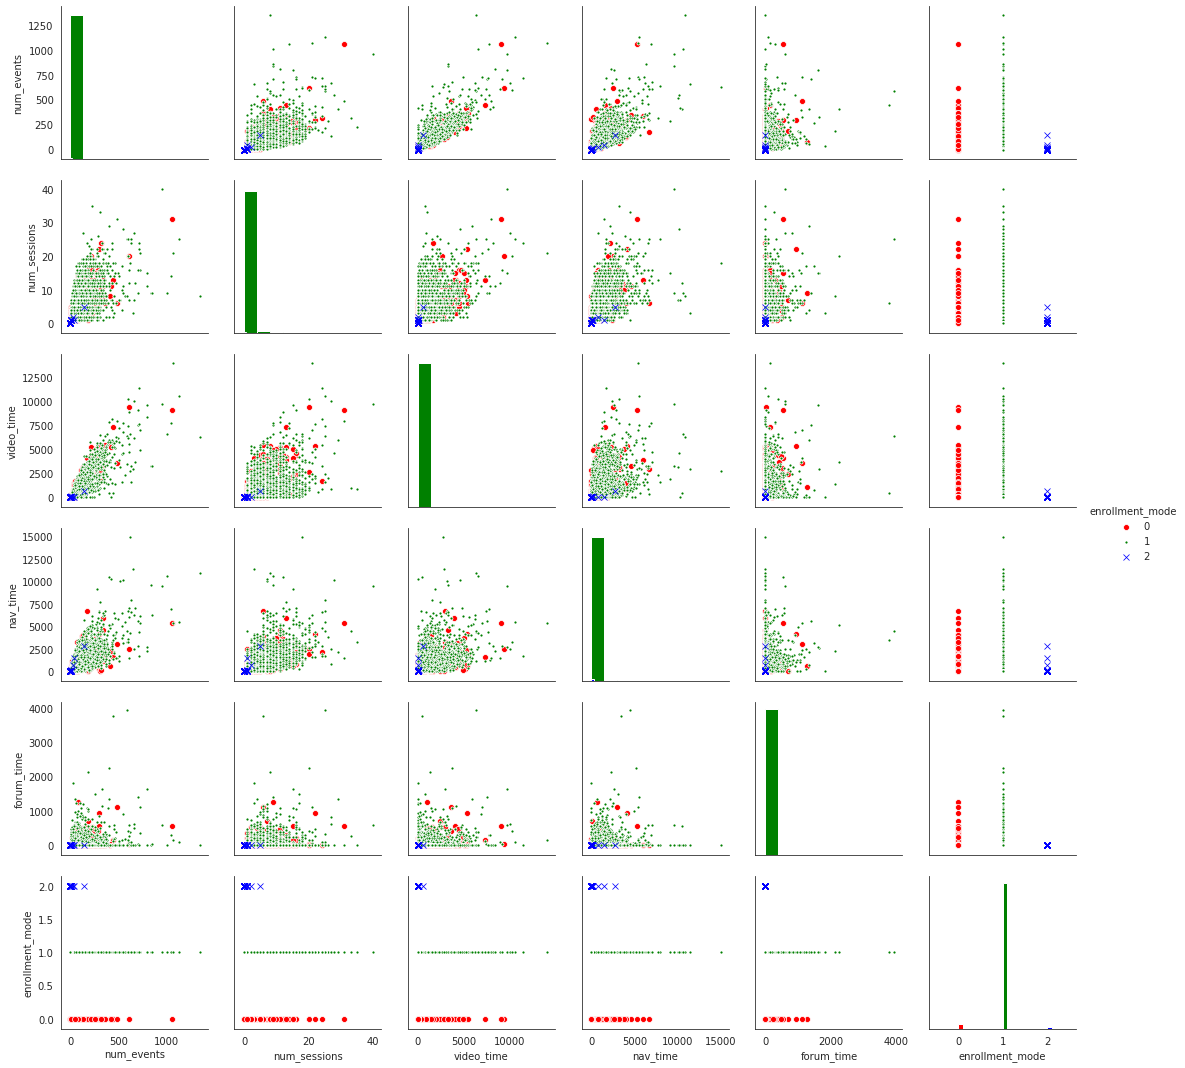

In [43]:
# First 5 features + target
pair_plot = sns.pairplot( df[(~(df['user_id'].isin(users_UY))) &
                             (df['enrollment_mode']!=-1)][ list(l_features[ : 5]) + [target] ],
                         hue='enrollment_mode',
                         palette={0:'red', 1:'green', 2:'blue'},
                         diag_kind='hist',
                         markers=['o', '.', 'x'],
                        )
plt.show()

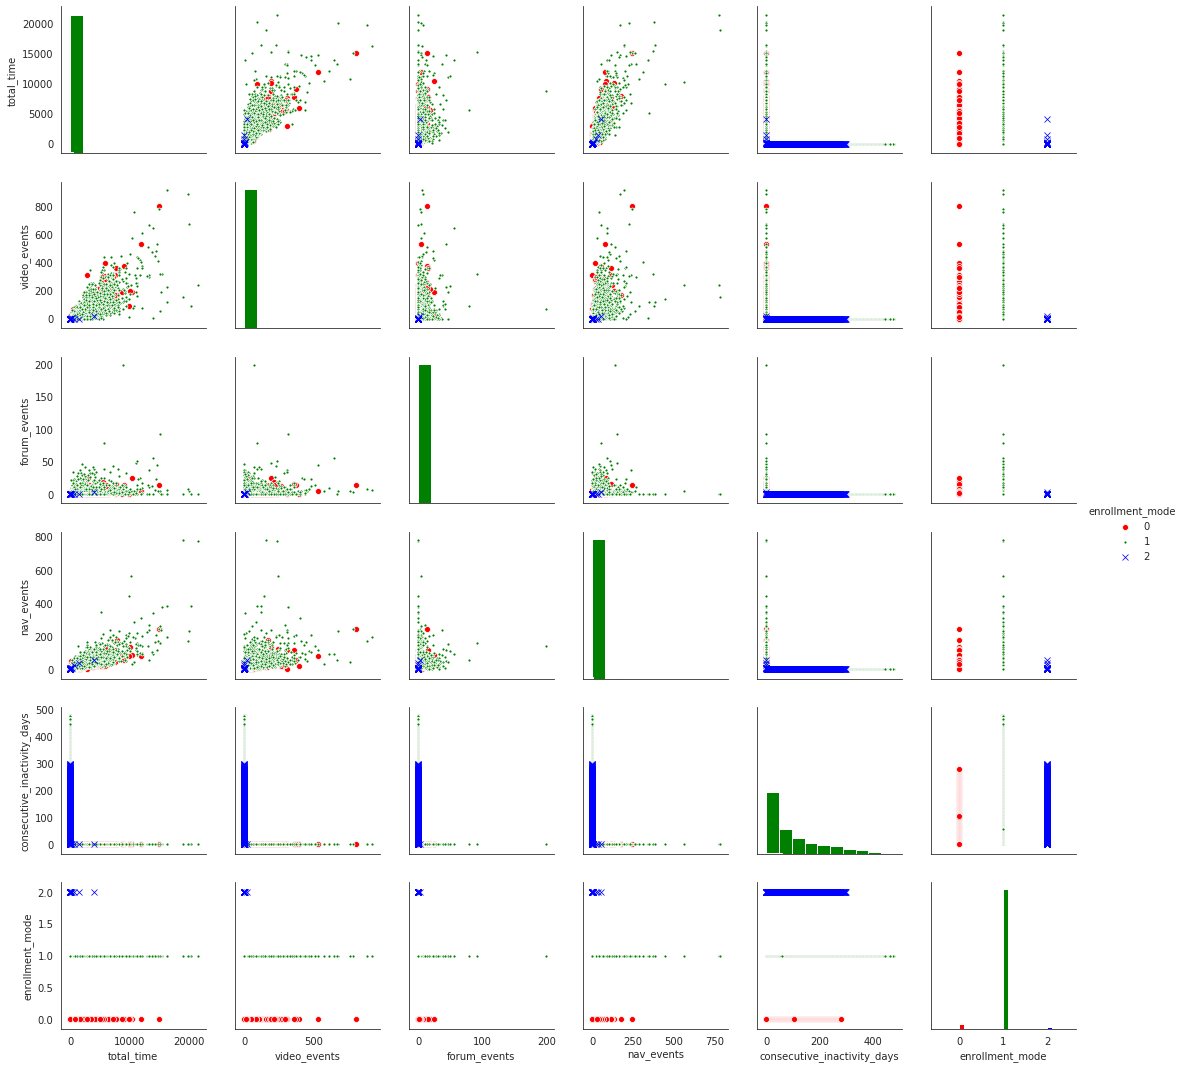

In [44]:
# Second 5 features + target
pair_plot = sns.pairplot( df[(~(df['user_id'].isin(users_UY))) &
                             (df['enrollment_mode']!=-1)][ list(l_features[5 : 10]) + [target] ],
                         hue='enrollment_mode',
                         palette={0:'red', 1:'green', 2:'blue'},
                         diag_kind='hist',
                         markers=['o', '.', 'x'],
                        )
plt.show()

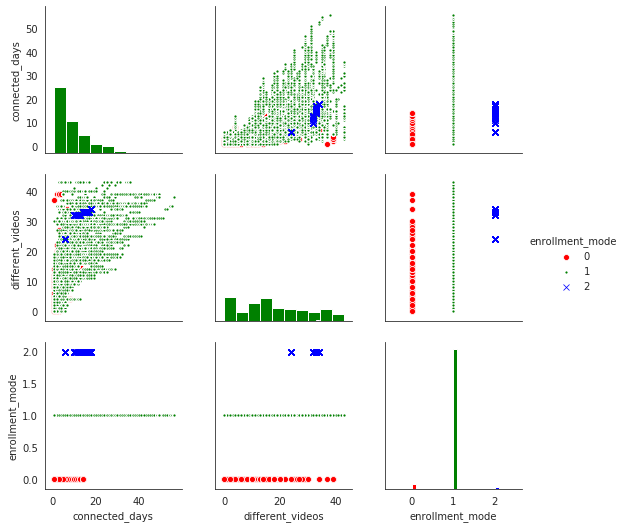

In [45]:
# Third (and last) 5 features + target
pair_plot = sns.pairplot( df[(~(df['user_id'].isin(users_UY))) &
                             (df['enrollment_mode']!=-1)][ list(l_features[10 : ]) + [target] ],
                         hue='enrollment_mode',
                         palette={0:'red', 1:'green', 2:'blue'},
                         diag_kind='hist',
                         markers=['o', '.', 'x'],
                        )
plt.show()

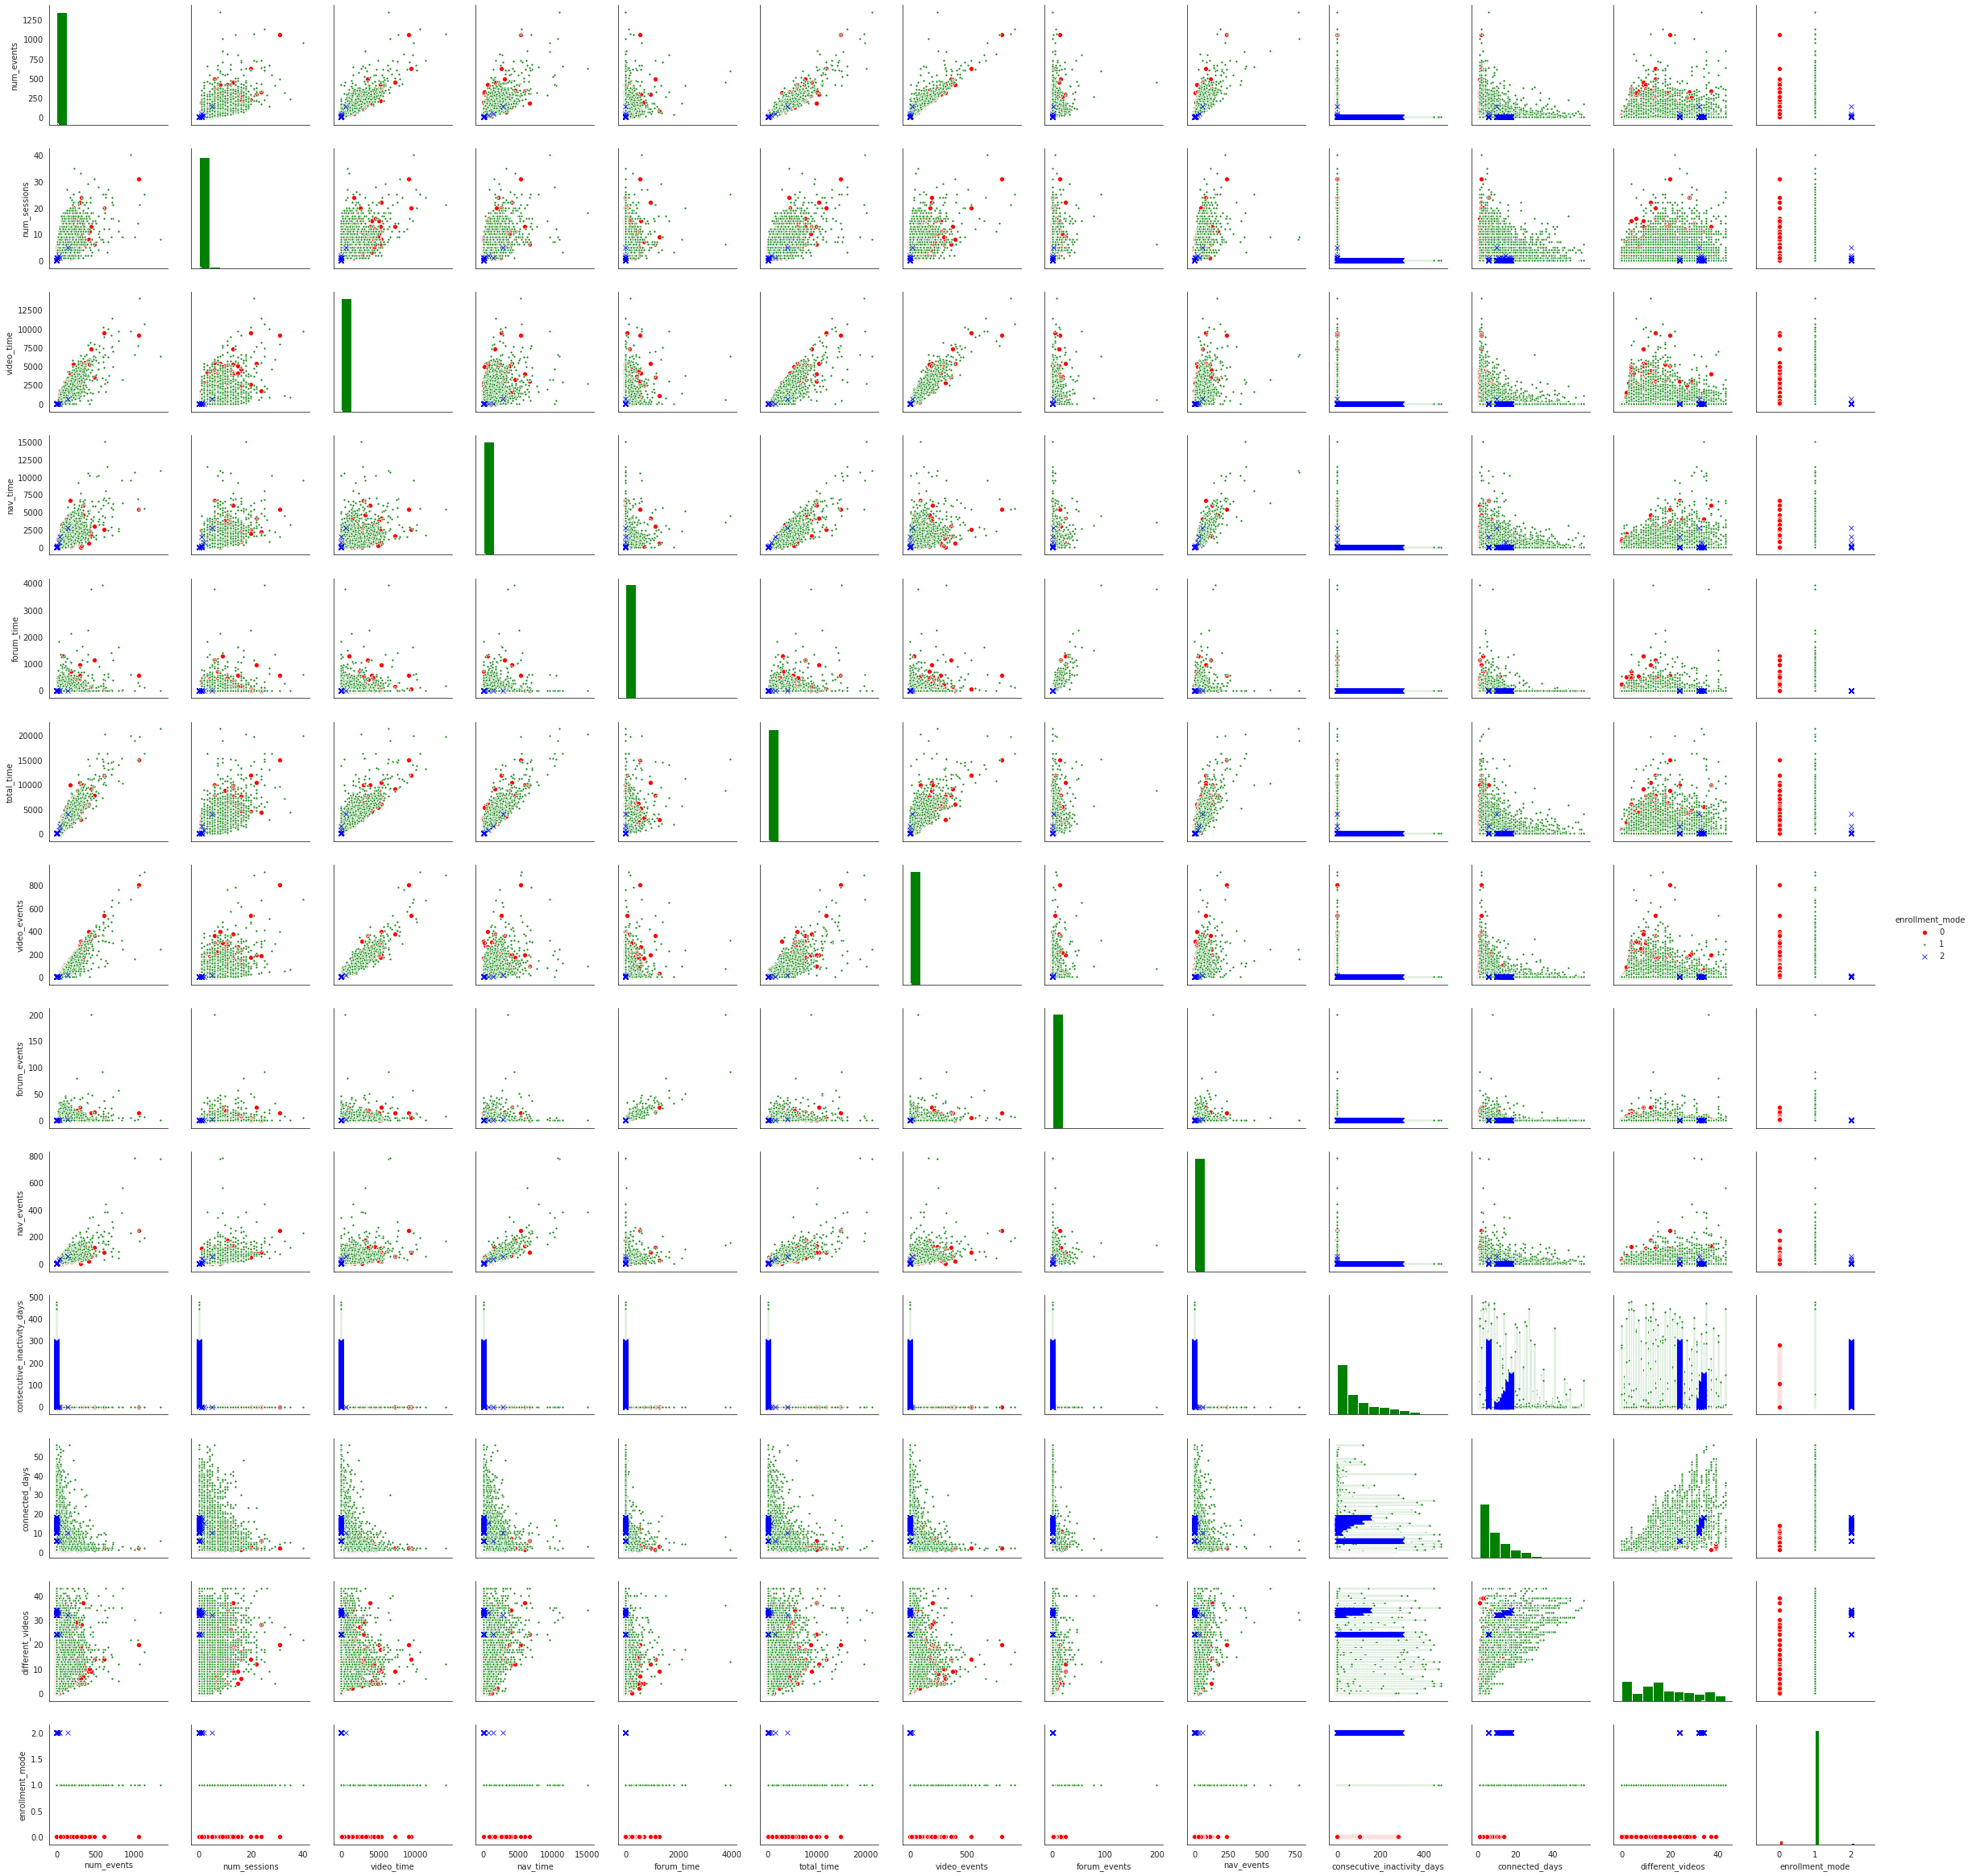

In [46]:
# Third (and last) 5 features + target
pair_plot = sns.pairplot( df[(~(df['user_id'].isin(users_UY))) &
                             (df['enrollment_mode']!=-1)][ list(l_features) + [target] ],
                         hue='enrollment_mode',
                         palette={0:'red', 1:'green', 2:'blue'},
                         diag_kind='hist',
                         markers=['o', '.', 'x'],
                        )
plt.show()

### Correlations

In [47]:
df.corr().round(decimals=3)

,user_id,num_events,num_sessions,video_time,problem_time,nav_time,forum_time,total_time,video_events,problem_events,forum_events,nav_events,consecutive_inactivity_days,connected_days,different_videos,different_problems,enrollment_mode
user_id,1.000,0.038,0.044,0.031,0.026,0.039,0.020,0.039,0.031,0.031,0.024,0.035,-0.142,-0.158,-0.107,-0.057,0.063
num_events,0.038,1.000,0.773,0.903,0.487,0.835,0.357,0.958,0.924,0.593,0.366,0.860,-0.122,-0.034,0.012,-0.015,-0.044
num_sessions,0.044,0.773,1.000,0.698,0.399,0.755,0.330,0.800,0.665,0.563,0.336,0.708,-0.161,-0.006,0.030,-0.006,-0.050
video_time,0.031,0.903,0.698,1.000,0.232,0.654,0.319,0.891,0.953,0.329,0.314,0.638,-0.109,-0.046,-0.015,-0.043,-0.056
problem_time,0.026,0.487,0.399,0.232,1.000,0.635,0.112,0.540,0.228,0.876,0.134,0.621,-0.066,0.009,0.053,0.055,0.006
nav_time,0.039,0.835,0.755,0.654,0.635,1.000,0.281,0.920,0.627,0.729,0.293,0.898,-0.126,-0.020,0.037,0.008,-0.034
forum_time,0.020,0.357,0.330,0.319,0.112,0.281,1.000,0.378,0.319,0.142,0.889,0.258,-0.049,-0.019,-0.004,-0.016,-0.020
total_time,0.039,0.958,0.800,0.891,0.540,0.920,0.378,1.000,0.852,0.628,0.377,0.857,-0.129,-0.035,0.015,-0.015,-0.047
video_events,0.031,0.924,0.665,0.953,0.228,0.627,0.319,0.852,1.000,0.315,0.313,0.615,-0.102,-0.045,-0.014,-0.040,-0.052
problem_events,0.031,0.593,0.563,0.329,0.876,0.729,0.142,0.628,0.315,1.000,0.165,0.707,-0.088,0.007,0.063,0.059,0.009


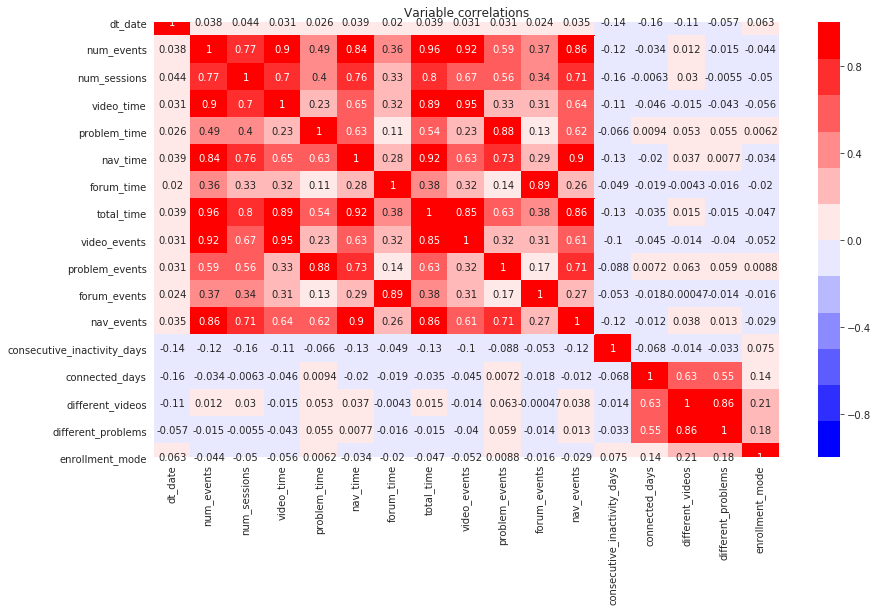

In [48]:
# correlation heatmap
cMap = plt.cm.get_cmap("bwr",lut=12) 

plt.figure( figsize=(14, 8))
plt.title('Variable correlations')
_ = sns.heatmap(df.corr().values, vmin=-1., vmax=1., cmap=cMap, annot=True, 
                xticklabels=list(df.columns[1:]),
                yticklabels=list(df.columns[1:]))

### Tests

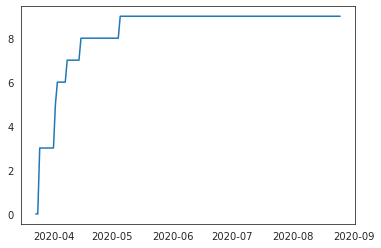

In [51]:
# TEST

# Select random user and get df for him
selected_user_id = unique_user_id[random.randint(0,len(unique_user_id))]
df_selected = df[df['user_id'] == selected_user_id]

plt.plot(df_selected['dt_date'], df_selected['different_problems'])
#plt.gcf().autofmt_xdate()

plt.title

plt.show()

In [52]:
selected_user_id  # user_id 332962 # user_id = 20129567

28206481

In [53]:
df[df['user_id']==selected_user_id].groupby(['enrollment_mode']).count()

,user_id,dt_date,num_events,num_sessions,video_time,problem_time,nav_time,forum_time,total_time,video_events,problem_events,forum_events,nav_events,consecutive_inactivity_days,connected_days,different_videos,different_problems
enrollment_mode,,,,,,,,,,,,,,,,,
1,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156


### Classify users and get zero day

In [54]:
# Make lists of:
#  users_yes > users who according to log data are verified
#  users_no  > users who according to log data are not verified yet

users_yes = []
users_maybe = []
users_no = []
for user in unique_user_id:
    if ((df['user_id']==user)&(df['enrollment_mode']==1)).sum():
#         if ((df['user_id']==user)&(df['enrollment_mode']==1)).idxmax() - ((df['user_id']==user)&(df['enrollment_mode']==0)).idxmax() > 100:
#             if ((df['user_id']==user)&(df['enrollment_mode']==0)).idxmax():
#                 users_maybe.append(user)
#             else:
#                 users_yes.append(user)                
#         else:
#             users_yes.append(user)
        users_yes.append(user)
    else:
        users_no.append(user)

print(f'Total {len(users_yes)} de {len(unique_user_id)}')

Total 367 de 918


In [55]:
# Add column 'dates_custom' with dates according to enrollment to verified
# Day 0 is the first day of verified mode

df['dates_custom'] = np.nan

for user in users_yes:
    indx = ((df['user_id']==user)&(df['enrollment_mode']==1)).idxmax()
    df.at[indx, 'dates_custom'] = 0
    valu = 0
    while (indx >= 0 and df.at[indx,'user_id'] == user and df.at[indx,'enrollment_mode'] != -1):
        df.at[indx,'dates_custom'] = valu
        indx = indx - 1
        valu = valu - 1
    indx = ((df['user_id']==user)&(df['enrollment_mode']==1)).idxmax()
    valu = 0
    while (indx < len(df) and df.at[indx,'user_id'] == user):
        df.at[indx, 'dates_custom'] = valu
        indx = indx + 1
        valu = valu + 1

In [56]:
(df['dates_custom'].isna()).sum()  # 121916

0

In [57]:
(~df['dates_custom'].isna()).sum()  # 106900

71846

In [58]:
# Plot principal component for all users_yes using dates_custom
# (day=0 is where users change their enrollment mode to verified)

cmap_name = 'viridis'
# variable = 
cmap = plt.cm.get_cmap(cmap_name) # ('hsv')
# cm_delta = 1/len(users_yes)
# cm_var = 0

plt.figure(figsize=(12,12))
for user in users_yes[:]:
    if user in users_UY:  # not taking Uruguay users
        continue
    nros = (df[df['user_id']==user].index)

    plt.plot(df[df['user_id']==user]['dates_custom'], 
             X_coded[nros], 
             # color = cmap(cm_var))
             color = cmap(df[(df['user_id']==user)&(df['dates_custom'].notnull())]['dates_custom'].iloc[0]/-200),
             marker='x'
            )
#     cm_var = cm_var + cm_delta

# plt.yscale('log')
plt.title('Principal component')
plt.ylabel('Principal component')
plt.xlabel('TIME (Days)')
# plt.text(x=-69, y=0.05, s='<<<<<< audit << || >> verified >>>>>>', fontsize=12)
# plt.vlines(x=0, ymin=df[variable].min(), 
#            ymax=df[variable].max(), colors='0.5', linestyles='dashed', label='')
plt.show()
#plt.savefig(f'{variable}.png')

NameError: name 'X_coded' is not defined

<Figure size 864x864 with 0 Axes>

In [59]:
# x = np.linspace(0, 2, 100)

# plt.plot(x, x, label='linear')  # Plot some data on the (implicit) axes.
# plt.plot(x, x**2, label='quadratic')  # etc.
# plt.plot(x, x**3, label='cubic')
# plt.xlabel('x label')
# plt.ylabel('y label')
# plt.title("Simple Plot")
# plt.legend()

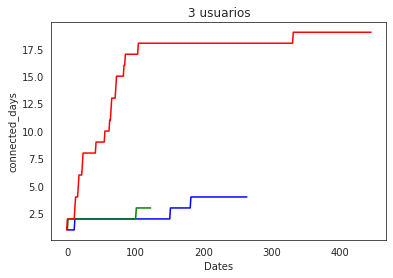

In [60]:
# Graph 3 users connected_days vs Custom Dates

selected_user_id_1 = users_yes[random.randint(0,len(users_yes))]
plt.plot(df[df['user_id']==selected_user_id_1]['dates_custom'], 
         df[df['user_id']==selected_user_id_1]['connected_days'], 
         'b')

selected_user_id_2 = users_yes[random.randint(0,len(users_yes))]
plt.plot(df[df['user_id']==selected_user_id_2]['dates_custom'], 
         df[df['user_id']==selected_user_id_2]['connected_days'], 
         'g')

selected_user_id_3 = users_yes[random.randint(0,len(users_yes))]
plt.plot(df[df['user_id']==selected_user_id_3]['dates_custom'], 
         df[df['user_id']==selected_user_id_3]['connected_days'], 
         'r')

plt.title("3 usuarios")
plt.ylabel('connected_days')
plt.xlabel('Dates')
plt.show()

In [61]:
# Plot all users for variable

def my_graph(variable, cmap_name='viridis'):
    cmap = plt.cm.get_cmap(cmap_name) # ('hsv')
    cm_delta = 1/len(users_yes)
    cm_var = 0

    plt.figure(figsize=(12,12))
    for user in users_yes:
        plt.plot(df[df['user_id']==user]['dates_custom'], 
                 df[df['user_id']==user][variable], 
                 # color = cmap(cm_var))
                 color = cmap(df[(df['user_id']==user)&(df['dates_custom'].notnull())]['dates_custom'].iloc[0]/-200))
        cm_var = cm_var + cm_delta

    plt.title(f'{variable} for VERIFIED USERS')
    plt.ylabel(variable)
    plt.xlabel('TIME (Days)')
    plt.text(x=-69, y=0.05, s='<<<<<< audit << || >> verified >>>>>>', fontsize=12)
    plt.vlines(x=0, ymin=df[variable].min(), 
               ymax=df[variable].max(), colors='0.5', linestyles='dashed', label='')
    plt.show()
    #plt.savefig(f'{variable}.png')

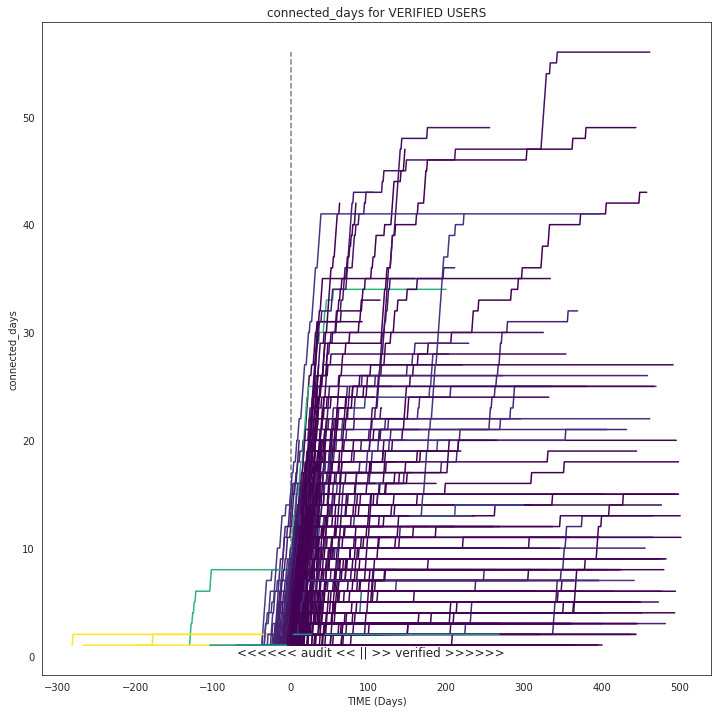

In [62]:
my_graph('connected_days') #, 'hsv')

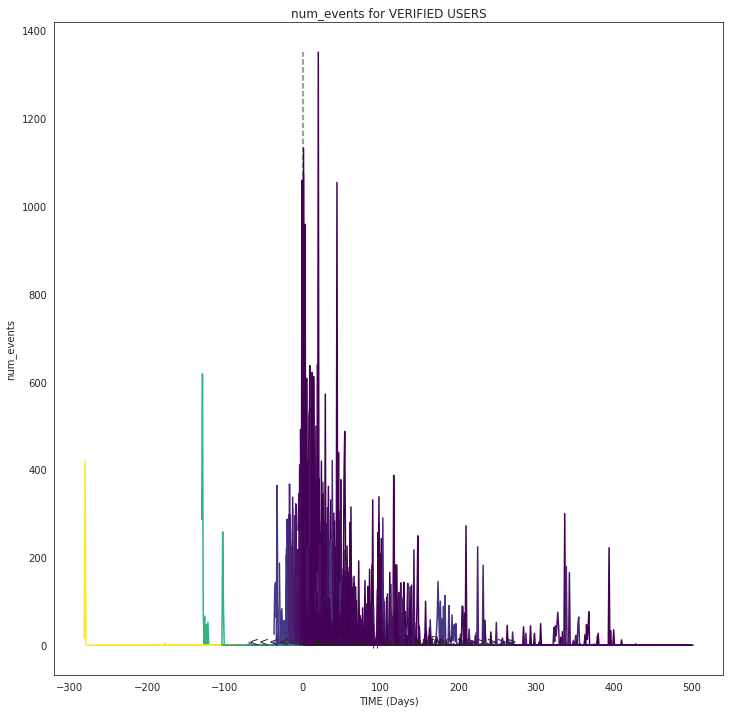

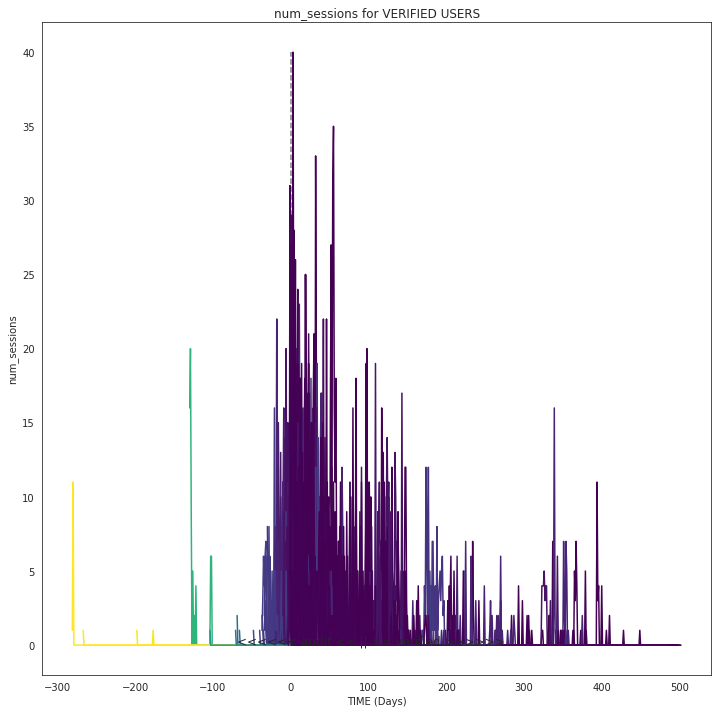

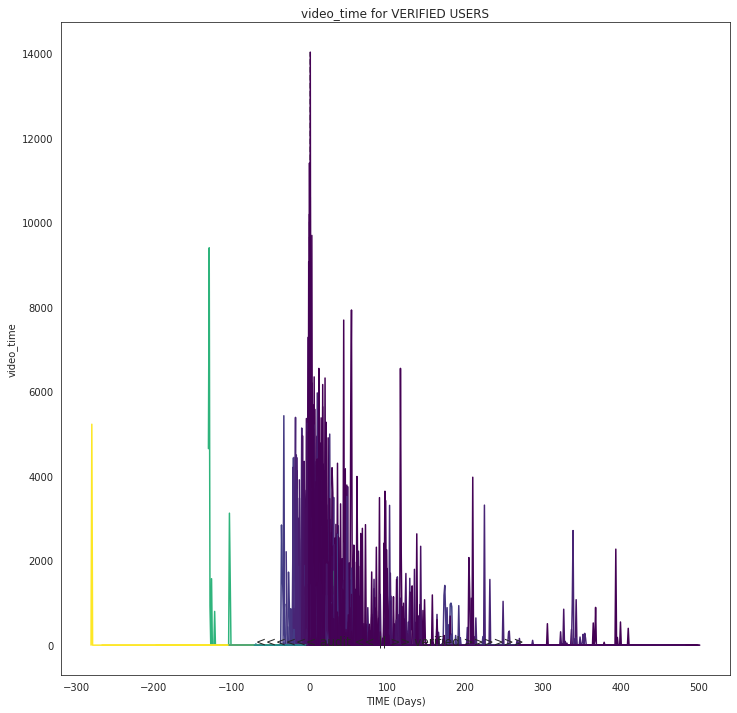

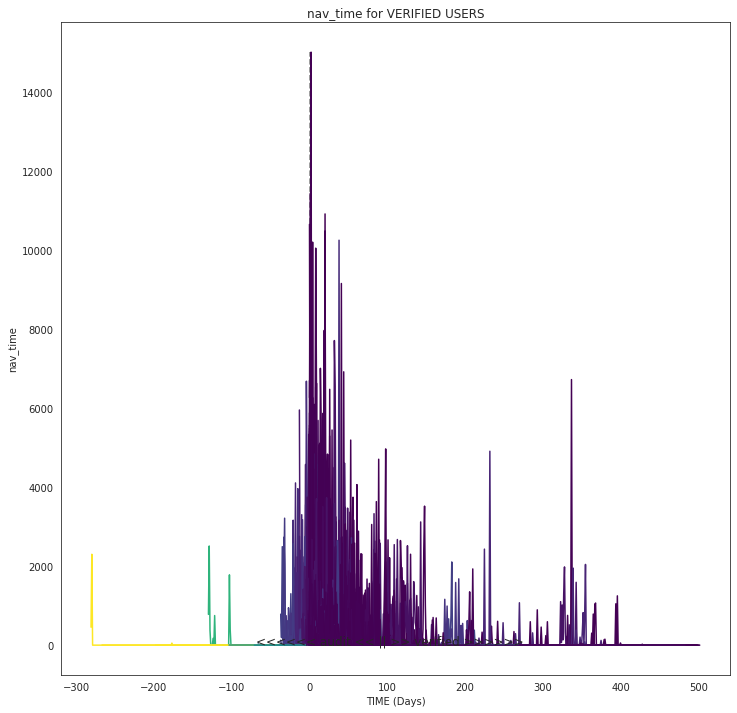

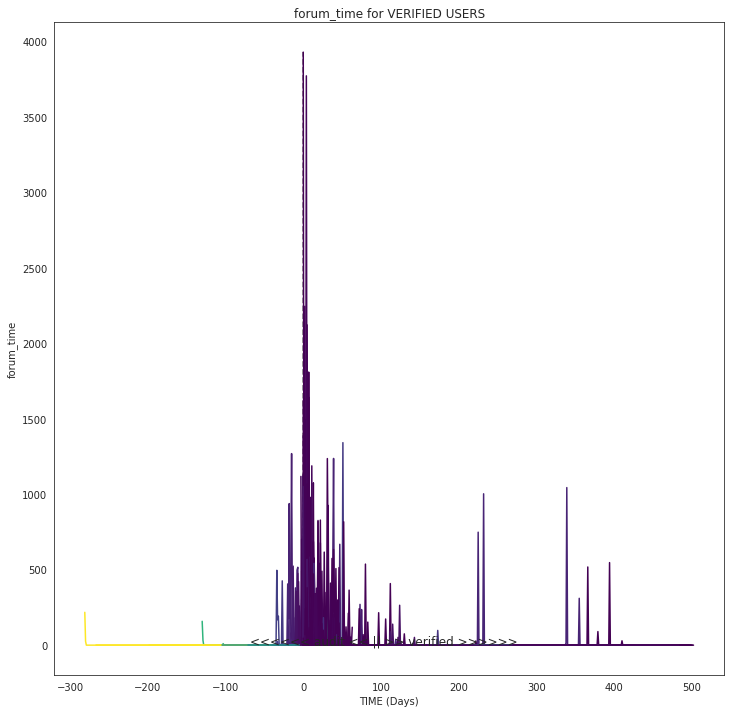

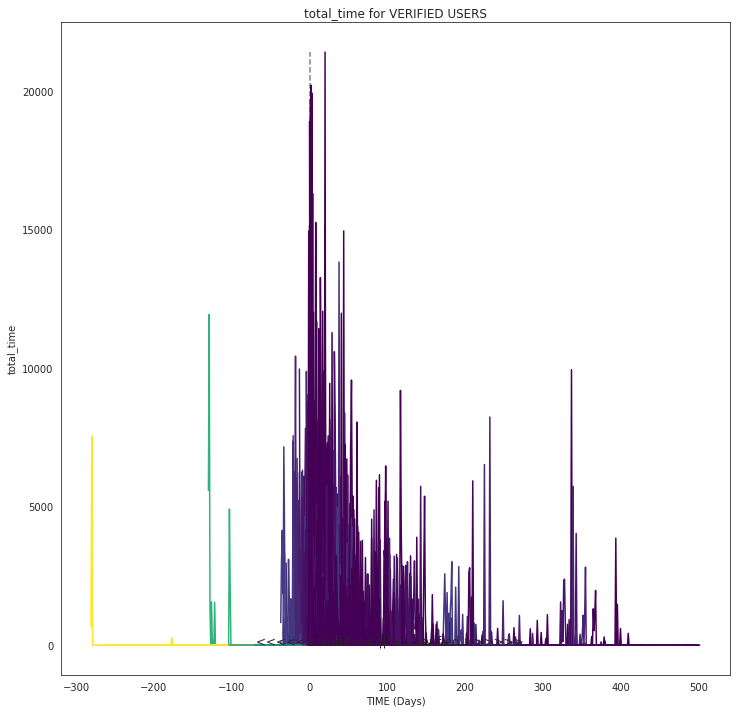

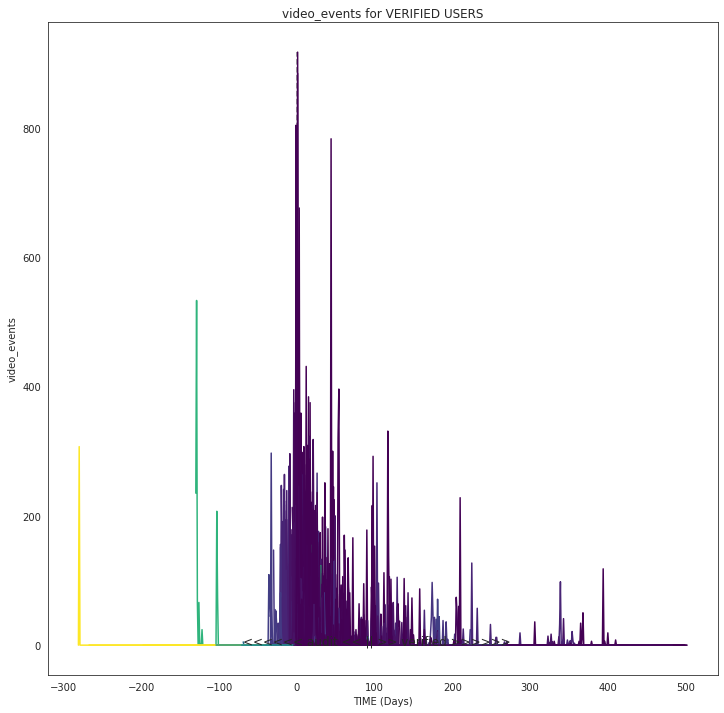

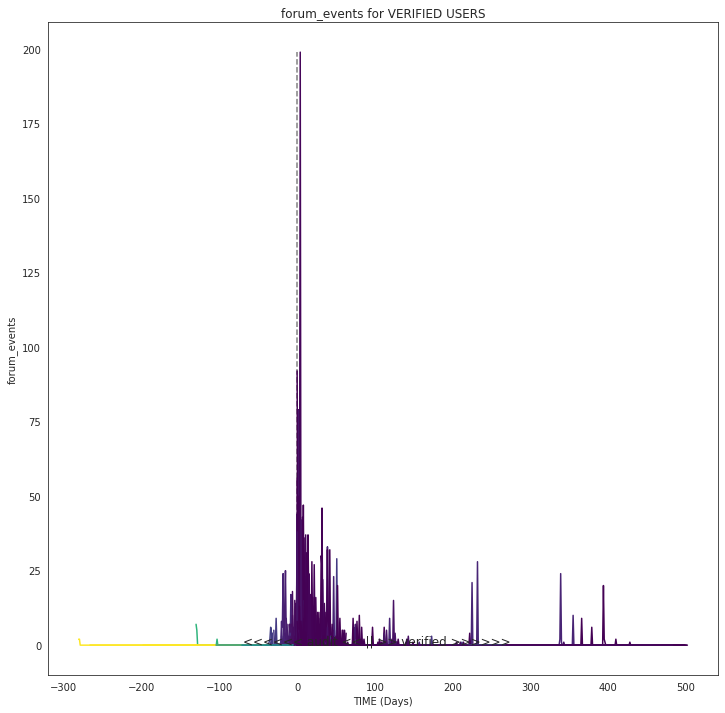

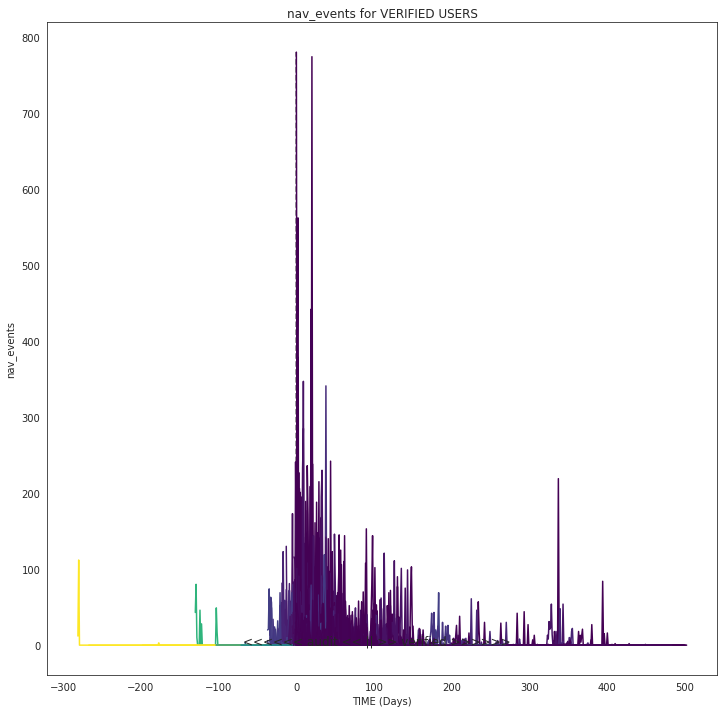

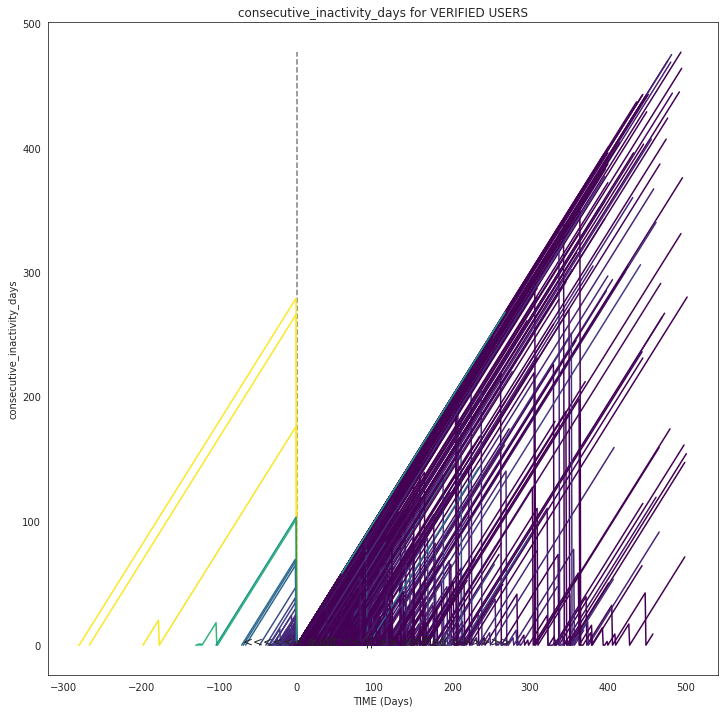

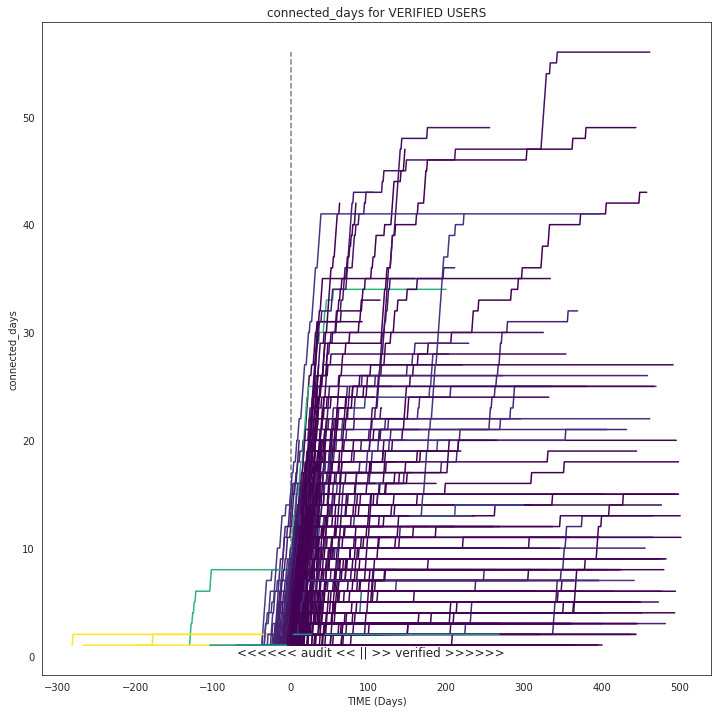

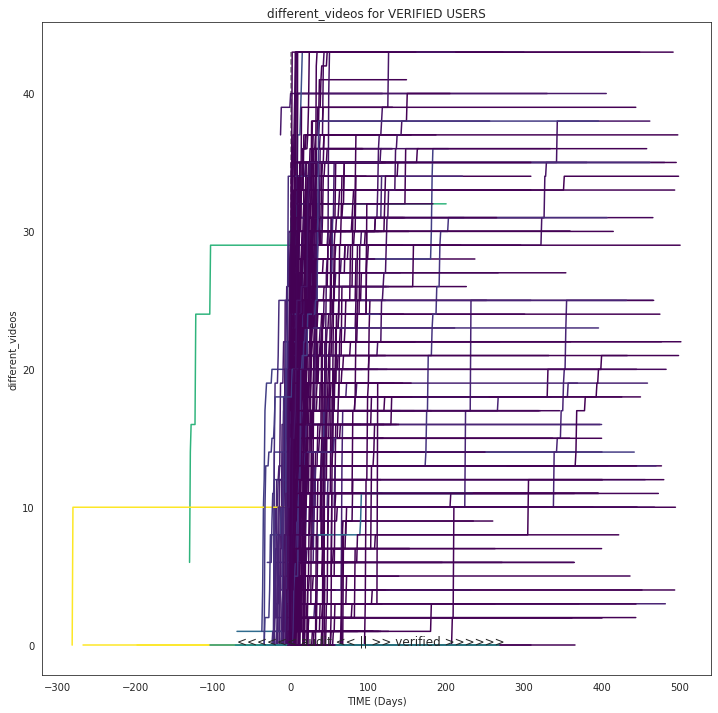

In [63]:
# Graph first variable
for l_feature in l_features:
    my_graph(l_feature)

In [64]:
# Plot all connected_days

def my_graph_2(variable, cmap_name='viridis'):
    cmap = plt.cm.get_cmap(cmap_name) # ('hsv')
    cm_delta = 1/len(users_yes)
    cm_var = 0

    plt.figure(figsize=(12,12))
    for user in users_yes:
        if df[df['user_id']==user]['dates_custom'].min()>-10:
            continue
        plt.plot(df[df['user_id']==user]['dates_custom'], 
                 df[df['user_id']==user][variable], 
                 # color = cmap(cm_var))
                 color = cmap(df[(df['user_id']==user)&(df['dates_custom'].notnull())]['dates_custom'].iloc[0]/-200))
        cm_var = cm_var + cm_delta

    plt.title(f'{variable} for VERIFIED USERS')
    plt.ylabel(variable)
    plt.xlabel('TIME (Days)')
    plt.text(x=-69, y=0.05, s='<<<<<< audit << || >> verified >>>>>>', fontsize=12)
    plt.vlines(x=0, ymin=df[variable].min(), 
               ymax=df[variable].max(), colors='0.5', linestyles='dashed', label='')
    plt.show()
    # plt.savefig(f'{variable}.png')

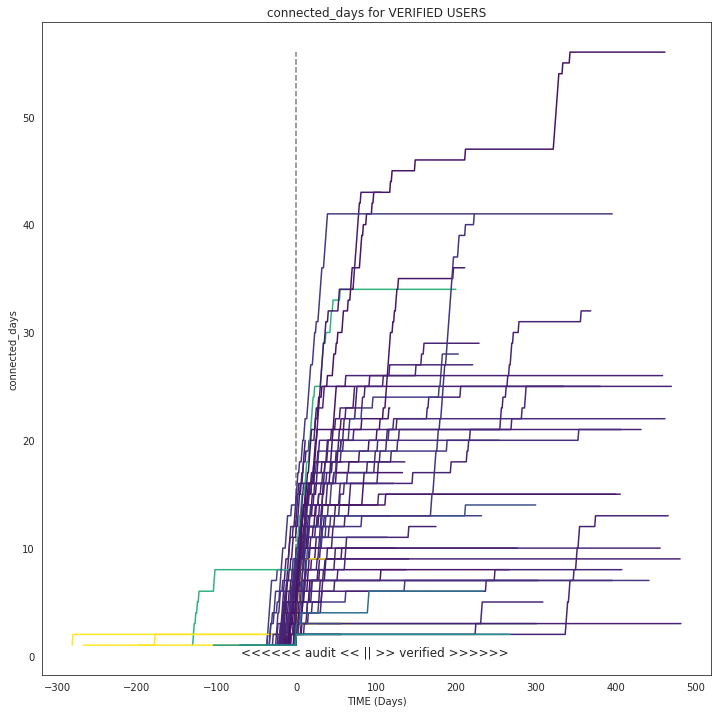

In [65]:
my_graph_2('connected_days') #, 'hsv')

## ML Algorithms

### Decision tree

In [66]:
# The decision tree classifier.
clf = tree.DecisionTreeClassifier(max_depth=4) #10)
# Training the Decision Tree
clf_train = clf.fit(df[df[target]!=2][l_features], df[df[target]!=2][target])

In [67]:
# Export/Print a decision tree in DOT format.
# print(tree.export_graphviz(clf_train, None))

# Create Dot Data
dot_data = tree.export_graphviz(clf_train, out_file=None,
                                feature_names=l_features, # list(df[l_features].columns.values), 
                                class_names=['audit', 'verified'],
                                rounded=True, filled=True
                               )  # Gini decides which attribute/feature should be placed at the root node, which features will act as internal nodes or leaf nodes

print(dot_data)

# Create Graph from DOT data
# graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
# Image(graph.create_png())

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="different_videos <= 1.5\ngini = 0.068\nsamples = 71066\nvalue = [2496, 68570]\nclass = verified", fillcolor="#399de5f6"] ;
1 [label="connected_days <= 1.5\ngini = 0.303\nsamples = 7755\nvalue = [1442, 6313]\nclass = verified", fillcolor="#399de5c5"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="consecutive_inactivity_days <= 18.5\ngini = 0.364\nsamples = 4746\nvalue = [1135, 3611]\nclass = verified", fillcolor="#399de5af"] ;
1 -> 2 ;
3 [label="consecutive_inactivity_days <= 1.5\ngini = 0.442\nsamples = 1727\nvalue = [570, 1157]\nclass = verified", fillcolor="#399de581"] ;
2 -> 3 ;
4 [label="gini = 0.486\nsamples = 390\nvalue = [162, 228]\nclass = verified", fillcolor="#399de54a"] ;
3 -> 4 ;
5 [label="gini = 0.424\nsamples = 1337\nvalue = [408, 929]\nclass = verified", fillcolor="#399de58f"] ;
3 -> 5 ;
6 [label="different_videos 

[Link a imagen de árbol con 4 niveles](https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0Anode%20%5Bshape%3Dbox%2C%20style%3D%22filled%2C%20rounded%22%2C%20color%3D%22black%22%2C%20fontname%3Dhelvetica%5D%20%3B%0Aedge%20%5Bfontname%3Dhelvetica%5D%20%3B%0A0%20%5Blabel%3D%22different_videos%20%3C%3D%201.5%5Cngini%20%3D%200.083%5Cnsamples%20%3D%2026546%5Cnvalue%20%3D%20%5B1156%2C%2025390%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5f3%22%5D%20%3B%0A1%20%5Blabel%3D%22consecutive_inactivity_days%20%3C%3D%2019.5%5Cngini%20%3D%200.448%5Cnsamples%20%3D%201906%5Cnvalue%20%3D%20%5B645%2C%201261%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de57d%22%5D%20%3B%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0A2%20%5Blabel%3D%22connected_days%20%3C%3D%203.5%5Cngini%20%3D%200.5%5Cnsamples%20%3D%20823%5Cnvalue%20%3D%20%5B411%2C%20412%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de501%22%5D%20%3B%0A1%20-%3E%202%20%3B%0A3%20%5Blabel%3D%22connected_days%20%3C%3D%201.5%5Cngini%20%3D%200.5%5Cnsamples%20%3D%20800%5Cnvalue%20%3D%20%5B411%2C%20389%5D%5Cnclass%20%3D%20audit%22%2C%20fillcolor%3D%22%23e581390e%22%5D%20%3B%0A2%20-%3E%203%20%3B%0A4%20%5Blabel%3D%22gini%20%3D%200.495%5Cnsamples%20%3D%20579%5Cnvalue%20%3D%20%5B318%2C%20261%5D%5Cnclass%20%3D%20audit%22%2C%20fillcolor%3D%22%23e581392e%22%5D%20%3B%0A3%20-%3E%204%20%3B%0A5%20%5Blabel%3D%22gini%20%3D%200.487%5Cnsamples%20%3D%20221%5Cnvalue%20%3D%20%5B93%2C%20128%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de546%22%5D%20%3B%0A3%20-%3E%205%20%3B%0A6%20%5Blabel%3D%22gini%20%3D%200.0%5Cnsamples%20%3D%2023%5Cnvalue%20%3D%20%5B0%2C%2023%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5ff%22%5D%20%3B%0A2%20-%3E%206%20%3B%0A7%20%5Blabel%3D%22consecutive_inactivity_days%20%3C%3D%20103.5%5Cngini%20%3D%200.339%5Cnsamples%20%3D%201083%5Cnvalue%20%3D%20%5B234%2C%20849%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5b9%22%5D%20%3B%0A1%20-%3E%207%20%3B%0A8%20%5Blabel%3D%22connected_days%20%3C%3D%201.5%5Cngini%20%3D%200.392%5Cnsamples%20%3D%20875%5Cnvalue%20%3D%20%5B234%2C%20641%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5a2%22%5D%20%3B%0A7%20-%3E%208%20%3B%0A9%20%5Blabel%3D%22gini%20%3D%200.467%5Cnsamples%20%3D%20587%5Cnvalue%20%3D%20%5B218%2C%20369%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de568%22%5D%20%3B%0A8%20-%3E%209%20%3B%0A10%20%5Blabel%3D%22gini%20%3D%200.105%5Cnsamples%20%3D%20288%5Cnvalue%20%3D%20%5B16%2C%20272%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5f0%22%5D%20%3B%0A8%20-%3E%2010%20%3B%0A11%20%5Blabel%3D%22gini%20%3D%200.0%5Cnsamples%20%3D%20208%5Cnvalue%20%3D%20%5B0%2C%20208%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5ff%22%5D%20%3B%0A7%20-%3E%2011%20%3B%0A12%20%5Blabel%3D%22consecutive_inactivity_days%20%3C%3D%204.5%5Cngini%20%3D%200.041%5Cnsamples%20%3D%2024640%5Cnvalue%20%3D%20%5B511%2C%2024129%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5fa%22%5D%20%3B%0A0%20-%3E%2012%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0A13%20%5Blabel%3D%22connected_days%20%3C%3D%208.5%5Cngini%20%3D%200.164%5Cnsamples%20%3D%203625%5Cnvalue%20%3D%20%5B326%2C%203299%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5e6%22%5D%20%3B%0A12%20-%3E%2013%20%3B%0A14%20%5Blabel%3D%22consecutive_inactivity_days%20%3C%3D%201.5%5Cngini%20%3D%200.26%5Cnsamples%20%3D%201818%5Cnvalue%20%3D%20%5B279%2C%201539%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5d1%22%5D%20%3B%0A13%20-%3E%2014%20%3B%0A15%20%5Blabel%3D%22gini%20%3D%200.3%5Cnsamples%20%3D%201073%5Cnvalue%20%3D%20%5B197%2C%20876%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5c6%22%5D%20%3B%0A14%20-%3E%2015%20%3B%0A16%20%5Blabel%3D%22gini%20%3D%200.196%5Cnsamples%20%3D%20745%5Cnvalue%20%3D%20%5B82%2C%20663%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5df%22%5D%20%3B%0A14%20-%3E%2016%20%3B%0A17%20%5Blabel%3D%22different_videos%20%3C%3D%2018.5%5Cngini%20%3D%200.051%5Cnsamples%20%3D%201807%5Cnvalue%20%3D%20%5B47%2C%201760%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5f8%22%5D%20%3B%0A13%20-%3E%2017%20%3B%0A18%20%5Blabel%3D%22gini%20%3D%200.159%5Cnsamples%20%3D%20515%5Cnvalue%20%3D%20%5B45%2C%20470%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5e7%22%5D%20%3B%0A17%20-%3E%2018%20%3B%0A19%20%5Blabel%3D%22gini%20%3D%200.003%5Cnsamples%20%3D%201292%5Cnvalue%20%3D%20%5B2%2C%201290%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5ff%22%5D%20%3B%0A17%20-%3E%2019%20%3B%0A20%20%5Blabel%3D%22consecutive_inactivity_days%20%3C%3D%2015.5%5Cngini%20%3D%200.017%5Cnsamples%20%3D%2021015%5Cnvalue%20%3D%20%5B185%2C%2020830%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5fd%22%5D%20%3B%0A12%20-%3E%2020%20%3B%0A21%20%5Blabel%3D%22connected_days%20%3C%3D%208.5%5Cngini%20%3D%200.059%5Cnsamples%20%3D%202982%5Cnvalue%20%3D%20%5B90%2C%202892%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5f7%22%5D%20%3B%0A20%20-%3E%2021%20%3B%0A22%20%5Blabel%3D%22gini%20%3D%200.107%5Cnsamples%20%3D%201573%5Cnvalue%20%3D%20%5B89%2C%201484%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5f0%22%5D%20%3B%0A21%20-%3E%2022%20%3B%0A23%20%5Blabel%3D%22gini%20%3D%200.001%5Cnsamples%20%3D%201409%5Cnvalue%20%3D%20%5B1%2C%201408%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5ff%22%5D%20%3B%0A21%20-%3E%2023%20%3B%0A24%20%5Blabel%3D%22different_videos%20%3C%3D%2028.5%5Cngini%20%3D%200.01%5Cnsamples%20%3D%2018033%5Cnvalue%20%3D%20%5B95%2C%2017938%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5fe%22%5D%20%3B%0A20%20-%3E%2024%20%3B%0A25%20%5Blabel%3D%22gini%20%3D%200.001%5Cnsamples%20%3D%2013719%5Cnvalue%20%3D%20%5B9%2C%2013710%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5ff%22%5D%20%3B%0A24%20-%3E%2025%20%3B%0A26%20%5Blabel%3D%22gini%20%3D%200.039%5Cnsamples%20%3D%204314%5Cnvalue%20%3D%20%5B86%2C%204228%5D%5Cnclass%20%3D%20verified%22%2C%20fillcolor%3D%22%23399de5fa%22%5D%20%3B%0A24%20-%3E%2026%20%3B%0A%7D)



![Arbol de Decisión - 4 niveles](images/graphviz_depth_4.png)